<p>Based on </p>[`"Deep Convolutional GAN (DCGAN) with MNIST" by Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/dcgan_mnist.ipynb)
<p>Online Version</p>[`"Image Generator of Digits"`](https://olgabelitskaya.github.io/kaggle_image_generator.html)
## ✒️ Styling, Libraries, and Helpful Functions

In [1]:
%%html
<style> 
h2,p {color:#196fc6; text-shadow:4px 4px 4px #ccc;} 
span {color:midnightblue; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:#196fc6;}; div.input_prompt {color:crimson;} 
div.output_area pre,div.output_subarea {font-size:15px; color:#196fc6;}
div.output_stderr pre {background-color:ghostwhite;}
</style>

In [2]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np,pandas as pd,tensorflow as tf
import cv2,pylab as pl,keras as ks
from keras.layers import Input,Dense,Activation,Reshape
from keras.layers import BatchNormalization,Flatten
from keras.layers import Conv2D,Conv2DTranspose,GlobalMaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam,Nadam
from keras import backend
from keras.layers.advanced_activations import PReLU,LeakyReLU
np.set_printoptions(precision=8); rn=np.random.randint(5000)
from keras import __version__
print('keras version:',__version__)
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0-rc1


In [3]:
def preprocess(x):    
    x=(x-.5)*2
    return np.clip(x,-1,1)
def deprocess(x):
    x=(x/2+.5)*255
#    np.place(x,x>220,255)
    x=np.clip(x,0,255)
    x=np.uint8(x)
    return x.reshape(28,28)
def latent_samples(n_samples,sample_size):
    return np.random.normal(loc=0,scale=1,
                            size=(n_samples,sample_size))
def trainable(model,trainable):
    for layer in model.layers:
        layer.trainable=trainable
def real_fake_labels(size):
    return np.ones([size,1]),np.zeros([size,1])
def display_images(generated_images):
    n_images=len(generated_images)
    rows=4; cols=n_images//rows    
    pl.figure(figsize=(cols,rows))
    for i in range(n_images):
        img=deprocess(generated_images[i])
        pl.subplot(rows,cols,i+1)
        pl.imshow(img,cmap=pl.cm.bone)
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()
def display_loss(losses):
    losses=np.array(losses)        
    pl.figure(figsize=(12,5))
    pl.plot(losses.T[0],'-o',c='#196fc6',lw=1,label='Discriminator')
    pl.plot(losses.T[1],'-o',c='crimson',lw=1,label='Generator')
    pl.title("Training Loss Functions"); pl.legend()

## ✒️ Data Loading & Preprocessing

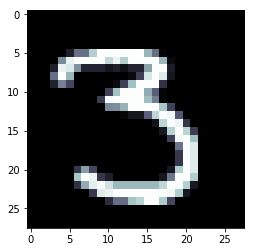

(42000, 784)

In [4]:
df_train=pd.read_csv("../input/train.csv")
id_images=["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
train_images=np.array(df_train[id_images])
train_images=train_images.astype('float32').reshape(-1,784)
pl.imshow(np.squeeze(train_images[rn].reshape(28,28)),
          cmap=pl.cm.bone);pl.show()
train_images.shape

In [5]:
df_test=pd.read_csv("../input/test.csv")
id_images=["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
test_images=np.array(df_test[id_images])
test_images=test_images.astype('float32').reshape(-1,784)
test_images.shape

(28000, 784)

In [6]:
np.argmax(train_images)/255

0.5215686274509804

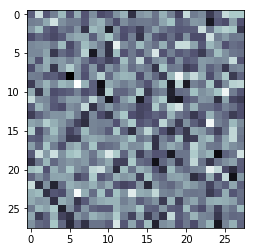

In [7]:
latent_sample784=latent_samples(1,784)
pl.imshow(np.squeeze(latent_sample784).reshape(28,28),
          cmap=pl.cm.bone); pl.show()

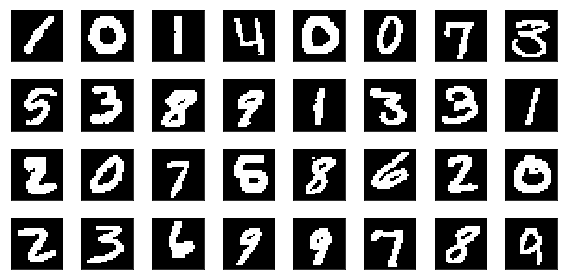

In [8]:
X_train_real=preprocess(train_images)
X_test_real=preprocess(test_images)
display_images(X_train_real[:32])
X_train_real=X_train_real.reshape(-1,28,28,1)
X_test_real=X_test_real.reshape(-1,28,28,1)

## ✒️ Keras DCGAN 

In [9]:
def dcgan_generator(input_size,leaky_alpha):
    return Sequential([
        Dense(784,input_shape=(input_size,)),
        Reshape(target_shape=(7,7,16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),       
        Conv2DTranspose(256,kernel_size=5,strides=2,padding='same'), 
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(1,kernel_size=5,strides=2,padding='same'),
        Activation('tanh')])
dcgan_generator_example=dcgan_generator(784,.01)
dcgan_generator_example.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 256)       102656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         6401      
__________

In [10]:
def dcgan_discriminator(leaky_alpha):
    return Sequential([        
        Conv2D(256,kernel_size=5,strides=2,
               padding='same',input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(16,kernel_size=5,strides=2,padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),        
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),        
        Dense(1),
        Activation('sigmoid')])
dcgan_discriminator_example=dcgan_discriminator(.01)
dcgan_discriminator_example.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 256)       6656      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          102416    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               615440    
__________

In [11]:
def dcgan(sample_size,leaky_alpha,
          g_learning_rate,g_beta_1,
          d_learning_rate,d_beta_1):
    backend.clear_session()    
    generator=dcgan_generator(sample_size,leaky_alpha)
    discriminator=dcgan_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate,beta_1=d_beta_1), 
                          loss='binary_crossentropy')
    gan=Sequential([generator,discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate,beta_1=g_beta_1), 
                loss='binary_crossentropy')    
    return gan,generator,discriminator  

In [12]:
def dcgan_train(g_learning_rate,g_beta_1,
                d_learning_rate,d_beta_1,
                leaky_alpha,smooth=.1,
                sample_size=128,epochs=100,
                batch_size=128,valid_size=32,
                show_details=True):    
    # labels for the batch size and the valid size
    y_train_real,y_train_fake=real_fake_labels(batch_size)
    y_valid_real,y_valid_fake=real_fake_labels(valid_size)
    # create a GAN, a generator and a discriminator
    gan,generator,discriminator=dcgan(sample_size,leaky_alpha,
                                      g_learning_rate,g_beta_1,
                                      d_learning_rate,d_beta_1)
    losses=[]
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real=X_train_real[i*batch_size:(i+1)*batch_size]
            # latent samples and the generated digit images
            batch_latent_samples=latent_samples(batch_size,sample_size)
            X_batch_fake=generator.predict_on_batch(batch_latent_samples)
            # train the discriminator to detect real and fake images
            trainable(discriminator,True)
            discriminator.train_on_batch(X_batch_real,y_train_real*(1-smooth))
            discriminator.train_on_batch(X_batch_fake,y_train_fake)
            # train the generator via GAN
            trainable(discriminator,False)
            gan.train_on_batch(batch_latent_samples,y_train_real)
        # evaluate
        X_valid_real=X_test_real[np.random.choice(len(X_test_real),
                                                  valid_size,replace=False)]
        valid_latent_samples=latent_samples(valid_size,sample_size)
        X_valid_fake=generator.predict_on_batch(valid_latent_samples)
        d_loss=discriminator.test_on_batch(X_valid_real,y_valid_real)
        d_loss+=discriminator.test_on_batch(X_valid_fake,y_valid_fake)
        g_loss=gan.test_on_batch(valid_latent_samples,y_valid_real) 
        losses.append((d_loss,g_loss))
        print("Epoch:{:>3}/{} | Discriminator Loss:{:>7.4f} | Generator Loss:{:>7.4f}"\
              .format(e+1,epochs,d_loss,g_loss))        
        if show_details and g_loss<4.5 and e>10: display_images(X_valid_fake)           
    if show_details: display_loss(losses)        
    return generator

Epoch:  1/100 | Discriminator Loss: 0.5037 | Generator Loss:15.7823
Epoch:  2/100 | Discriminator Loss: 0.0000 | Generator Loss:16.1181
Epoch:  3/100 | Discriminator Loss:16.2754 | Generator Loss: 4.2396
Epoch:  4/100 | Discriminator Loss:15.8495 | Generator Loss: 4.5011
Epoch:  5/100 | Discriminator Loss:15.4142 | Generator Loss: 5.3629
Epoch:  6/100 | Discriminator Loss: 6.0257 | Generator Loss: 4.7718
Epoch:  7/100 | Discriminator Loss:11.3992 | Generator Loss: 9.2700
Epoch:  8/100 | Discriminator Loss: 5.5127 | Generator Loss: 5.1917
Epoch:  9/100 | Discriminator Loss: 3.4735 | Generator Loss: 2.9718
Epoch: 10/100 | Discriminator Loss: 7.6814 | Generator Loss: 7.5463
Epoch: 11/100 | Discriminator Loss: 8.7184 | Generator Loss: 8.0410
Epoch: 12/100 | Discriminator Loss: 6.4785 | Generator Loss: 6.3564
Epoch: 13/100 | Discriminator Loss: 5.9250 | Generator Loss: 5.7527
Epoch: 14/100 | Discriminator Loss:14.3748 | Generator Loss:12.7067
Epoch: 15/100 | Discriminator Loss: 4.7027 | Gen

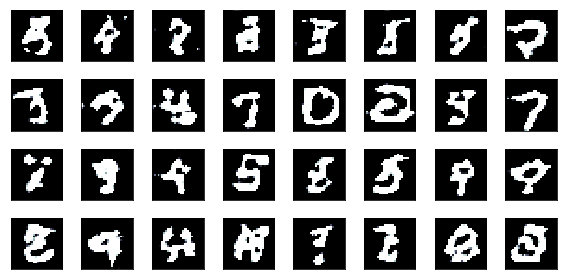

Epoch: 27/100 | Discriminator Loss: 5.6727 | Generator Loss: 6.4740
Epoch: 28/100 | Discriminator Loss: 6.7078 | Generator Loss: 6.4418
Epoch: 29/100 | Discriminator Loss: 5.8375 | Generator Loss: 6.1183
Epoch: 30/100 | Discriminator Loss: 7.3222 | Generator Loss: 6.8203
Epoch: 31/100 | Discriminator Loss: 7.6757 | Generator Loss: 7.6702
Epoch: 32/100 | Discriminator Loss: 7.1850 | Generator Loss: 6.9673
Epoch: 33/100 | Discriminator Loss: 6.7878 | Generator Loss: 6.5778
Epoch: 34/100 | Discriminator Loss:15.3668 | Generator Loss:15.4468
Epoch: 35/100 | Discriminator Loss: 5.5877 | Generator Loss: 5.7931
Epoch: 36/100 | Discriminator Loss: 9.0877 | Generator Loss: 8.2180
Epoch: 37/100 | Discriminator Loss: 7.5428 | Generator Loss: 6.4184
Epoch: 38/100 | Discriminator Loss: 7.3714 | Generator Loss: 7.3369
Epoch: 39/100 | Discriminator Loss: 8.4325 | Generator Loss: 7.9929
Epoch: 40/100 | Discriminator Loss: 8.0984 | Generator Loss: 8.3711
Epoch: 41/100 | Discriminator Loss: 8.2936 | Gen

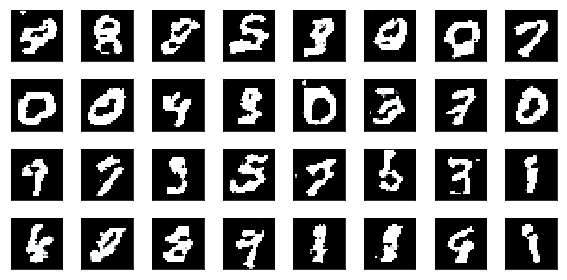

Epoch: 65/100 | Discriminator Loss: 4.5561 | Generator Loss: 5.8591
Epoch: 66/100 | Discriminator Loss: 4.2293 | Generator Loss: 5.9979
Epoch: 67/100 | Discriminator Loss: 4.1620 | Generator Loss: 5.1218
Epoch: 68/100 | Discriminator Loss: 5.7724 | Generator Loss: 6.3257
Epoch: 69/100 | Discriminator Loss: 6.3726 | Generator Loss: 7.0670
Epoch: 70/100 | Discriminator Loss: 5.0701 | Generator Loss: 5.8716
Epoch: 71/100 | Discriminator Loss: 7.0270 | Generator Loss: 8.0804
Epoch: 72/100 | Discriminator Loss: 4.9691 | Generator Loss: 5.5488
Epoch: 73/100 | Discriminator Loss: 5.2729 | Generator Loss: 6.0947
Epoch: 74/100 | Discriminator Loss: 7.5405 | Generator Loss: 8.2521
Epoch: 75/100 | Discriminator Loss: 6.9330 | Generator Loss: 7.2249
Epoch: 76/100 | Discriminator Loss: 5.8486 | Generator Loss: 6.1160
Epoch: 77/100 | Discriminator Loss: 5.8142 | Generator Loss: 6.5239
Epoch: 78/100 | Discriminator Loss: 8.1019 | Generator Loss: 8.3202
Epoch: 79/100 | Discriminator Loss: 8.3730 | Gen

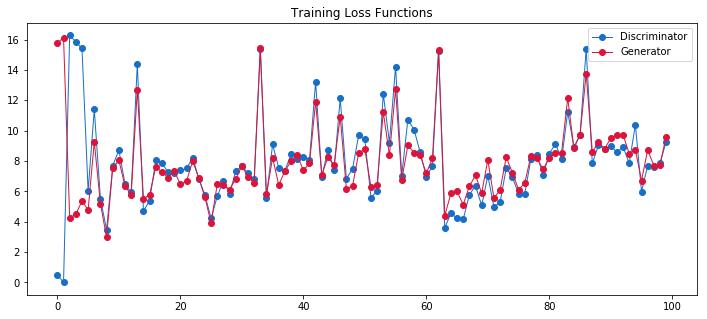

In [13]:
dcgan_train(g_learning_rate=.0001,g_beta_1=.8, 
            d_learning_rate=.001,d_beta_1=.8, 
            leaky_alpha=.01);